# Results

The script below runs the model, outputs the results, and generates:
- [Figures 1 & 2: Non-stationarity impacts](#fig1)
- [Crop coefficient figure](#fig3)
- [Dynamic Stress-Yield Relationships](#yields)
- [LGP impacts on yield](#lgp)

Start at [Step 2](#import) where the 10,000 simulations are imported in to make figures for 180-day variety.

Start at [Step 3](#import2) where the 10,000 simulations for the groups of varieties are made.

TODOs:
- Eventually convert the figure making part of this notebook to a python notebook
- Need to run the model for the varieties figure and export those results.

Last updated: 30 August 2020

In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# Uncomment for black background figure
# plt.rcParams.update({
#     "grid.color": "white",
#     'hatch.color': 'k',
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     'patch.facecolor': ([0, 1, 1]),
#     'grid.alpha': 0.4,
#     "text.color": "lightgray",
#     "axes.facecolor": "black",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "lightgray",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

/Users/kellycaylor/opt/anaconda3/envs/maize-Toff/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [3]:
def run(n_sim = 2, burn_in = 60,  station = 'OL JOGI FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad'):
    """ Set up model conditions for model runs. 

    Usage: run(n_sim, burn_in, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = TODO

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    # doy = abs(burn_in - pd_sim) # absolute value
    doy = pd_sim - burn_in
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
    
    s0_climate = Climate(data_file=data_file, station=station, interval=interval)
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)

    
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy)
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
    models = [CropModel(
                  crop=crop,
                  climate=Climate(alpha_r=s0_climate.alpha_r, lambda_r=s0_climate.lambda_r),
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    
    output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    print("Step 5: \n\t... Subsetting data to growing period.")
 
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Output the dynamic stress and yield values (just added this 08-17-2020)
    # old: x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress) for df in output] #for i in np.arange(n_sim)
    print("Step 6: \n\t... Calculating plant stress."

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(lgp, m, b)) for df in output] # I have no clue whether this will work
    
    #print(output[0][start:end].s)
    rf = [df[start:end]['R'].sum() for df in output]
    
    return x, rf, int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in

x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run()

SyntaxError: invalid syntax (<ipython-input-3-0a1c330a766e>, line 90)

[(0.5114818296192012, 0.8442497329150289, 0.6721507869033555),
 (0.46118865347588606, 1.0, 0.0)]

5924
s star 0.37128 sw 0.25228


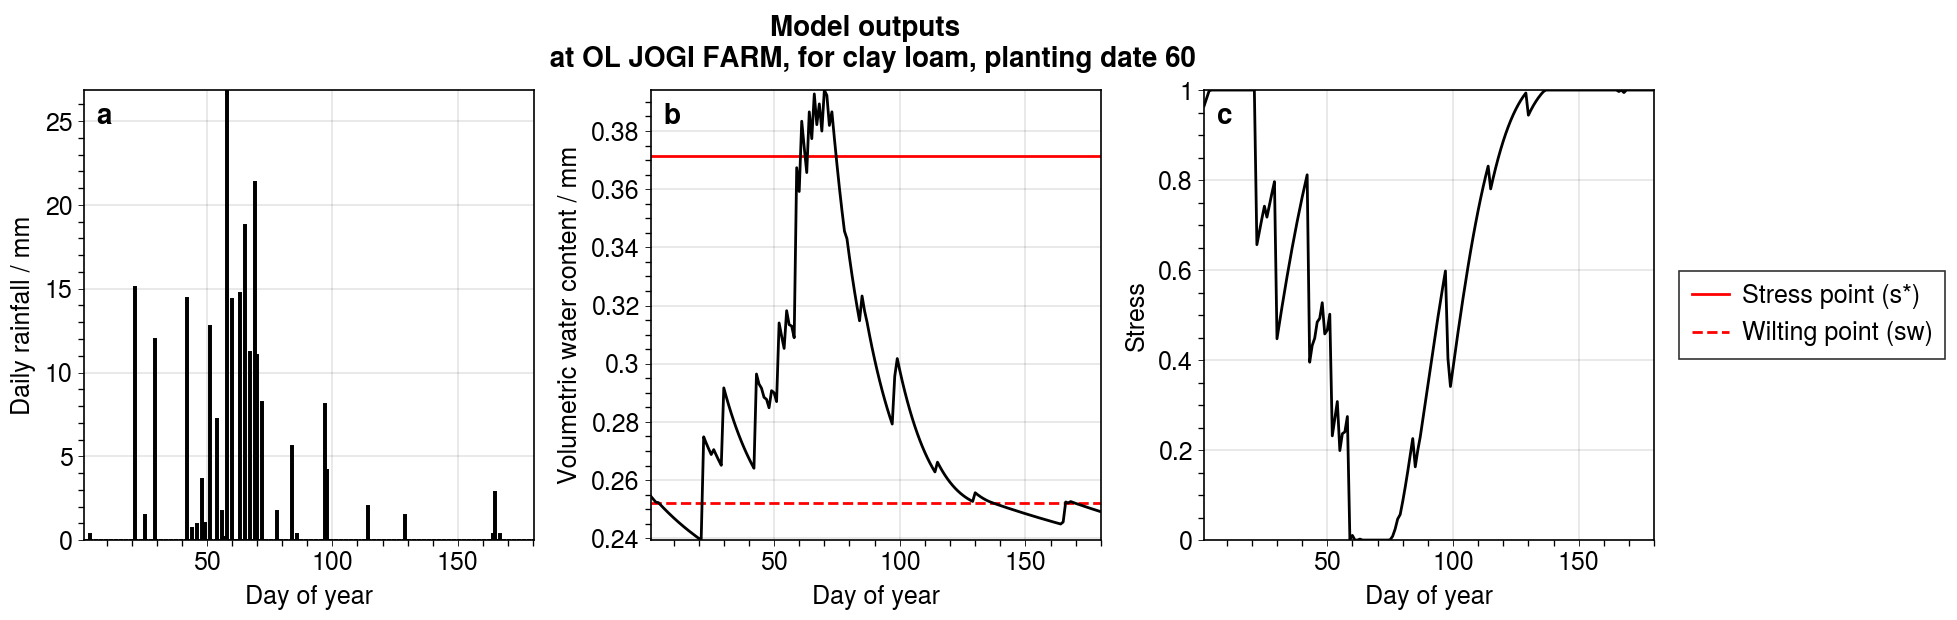

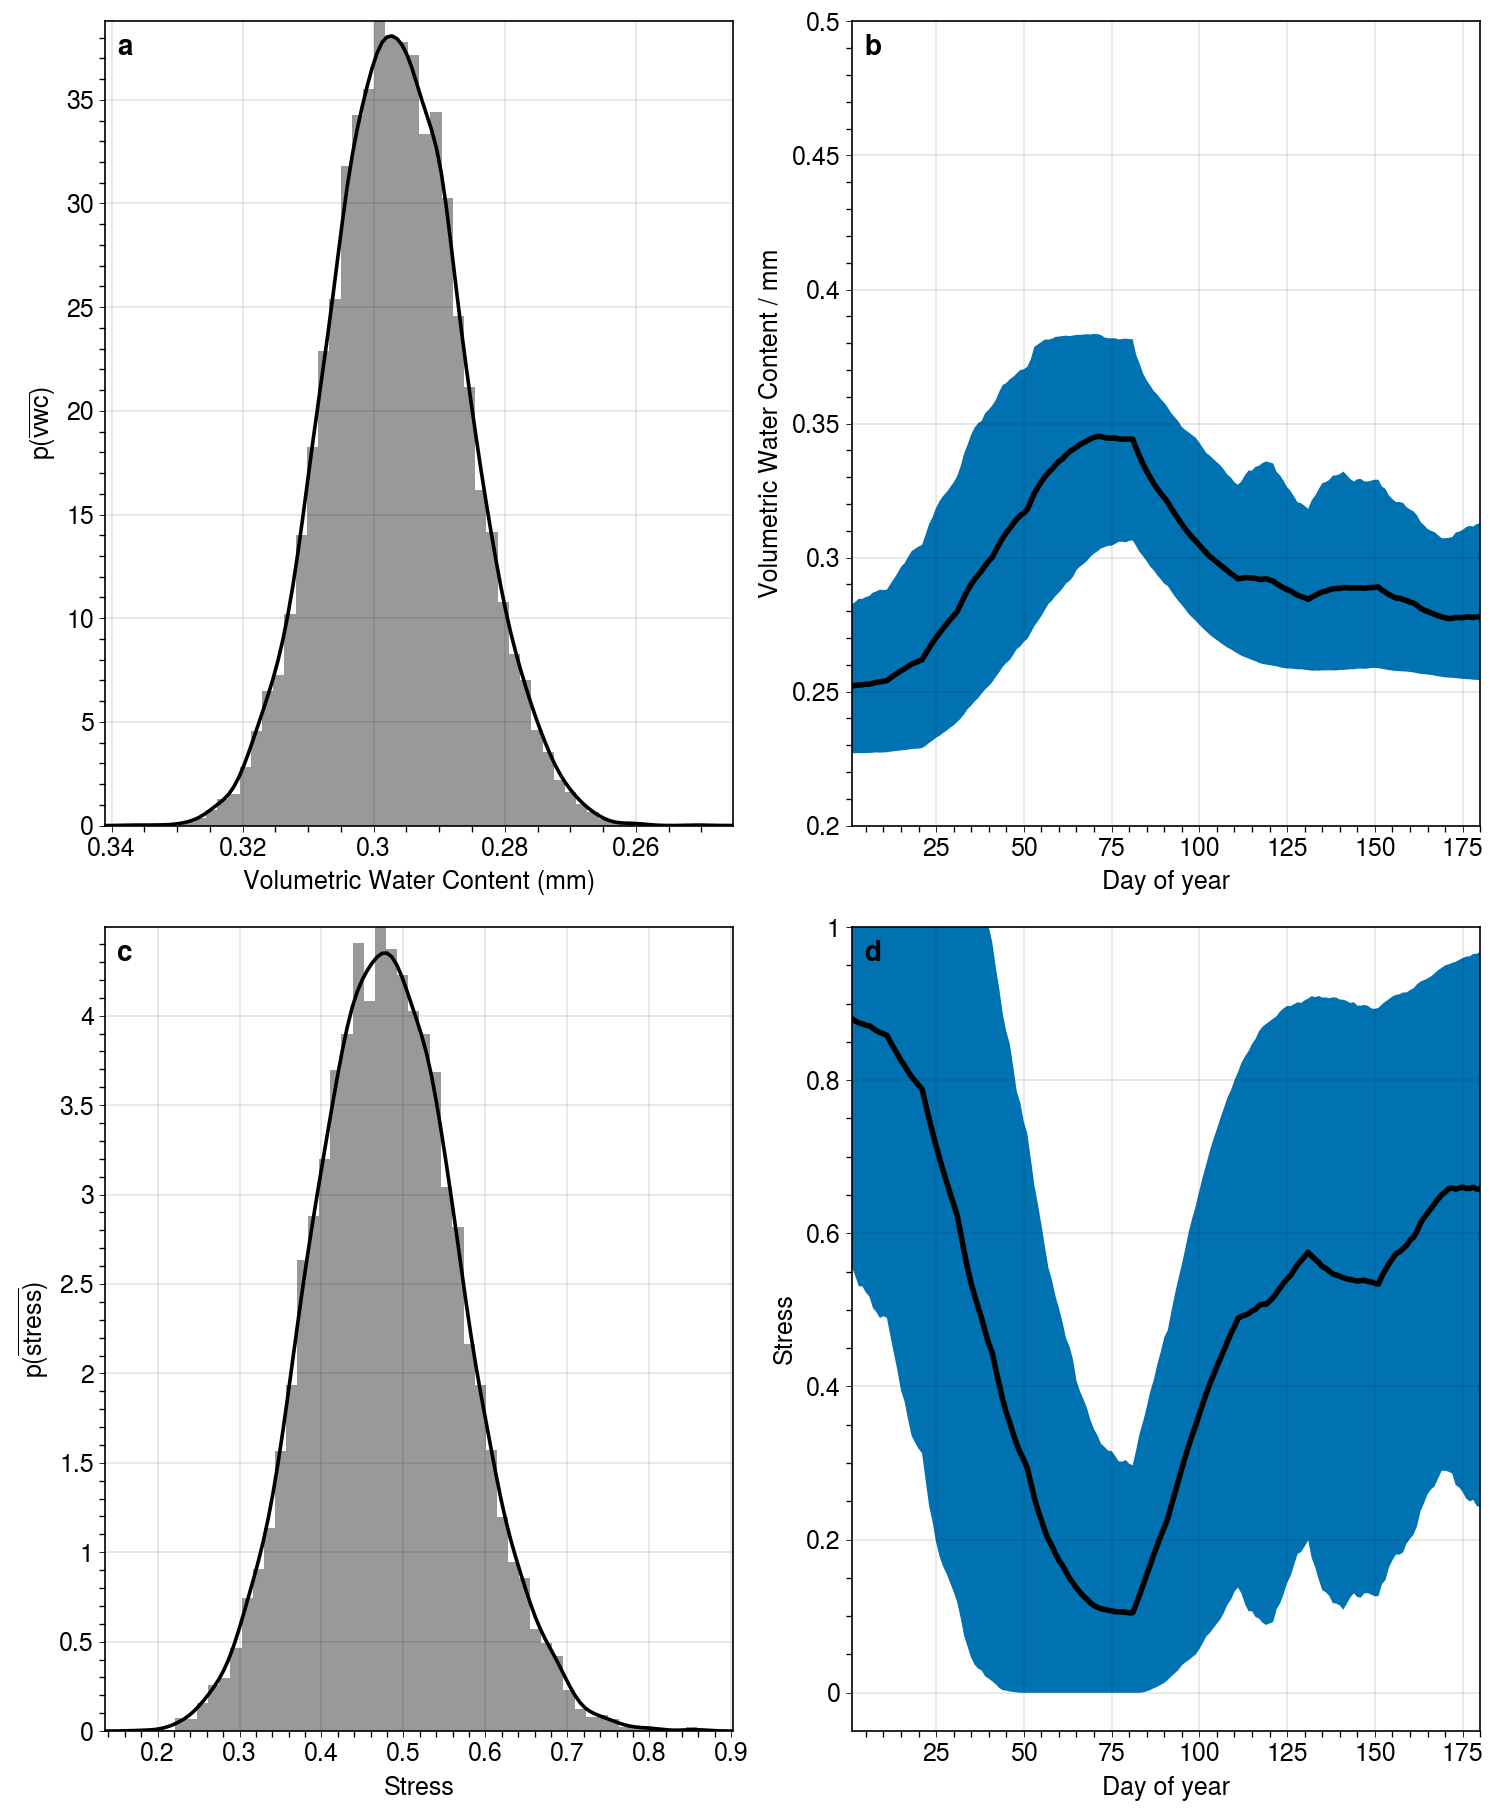

In [33]:
# 4. Generating the figures

def figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function

    """
    # Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    #col='white'
    
    # Since we're using the reimported outputs, we can set start and end to 0 and 180
    #start = 0
    #end = 180
    #burn_in = 1
    # If we were using the raw output we'd need to have the previous start and end values
    # That's what we're doing!
    
    start = 0 # 60
    end = 180 # 240
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    print(lowest)
    lowest=989
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    #axs[0,0].format(xlabel='Day of season')
    axs[0,0].format(xlabel='Day of year')
    #axs[0,0].format(xlim=(60, 240))
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
    #axs[0,2].format(xlabel='Day of season')
    axs[0,2].format(xlabel='Day of year')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    #axs[0,1].format(xlim=(60, 240))
    #plt.savefig('../output/6-results/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
    avg_daily = avg_daily*Soil(texture).n; avg_daily
    avg_daily_t = avg_daily.T; avg_daily_t
    daily_mean = avg_daily.mean(axis=1); daily_mean
    daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
    daily_mean
    #data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    x = np.arange(1, len(daily_mean)+1, 1)
    # use this for raw output
    #x = np.arange(60, 240, 1)

    # set custom x axis
    #axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))
    
    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index + 1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    #axs[1,1].format(xlabel='Day of season')
    axs[1,1].format(xlabel='Day of year')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    #axs.format(
    # set custom x axis
    #axs[1,1].format(xlim=(60, 240)) #
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    
    #plt.savefig('../output/6-results/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

In [27]:
# If needing to figure out a better time series to plot, use the following:

# return list of some of lowest time series

s_min = []
no_sims = np.arange(0,n_sim)

for i in no_sims:
    #print(output[i][start:end]['s'].min())
    _s_min = output[i][start:end]['s'].min()
    s_min.append(_s_min)
result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

# which simulation has the smallest s value?
lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
print(lowest)

5924


In [28]:
result.s_min.sort_values().head(50)

# There is probably a better way to do this that locates a simulation with a value above stress point 
# and below wilting point

5924    0.448744
5159    0.466545
5699    0.467588
5323    0.477529
3246    0.486603
8596    0.493264
3818    0.497308
1726    0.499078
366     0.500902
7644    0.501038
7435    0.502820
4699    0.504903
2049    0.505297
7315    0.505779
9120    0.506201
3340    0.506969
4402    0.507210
8754    0.507551
3408    0.507739
2381    0.507917
8600    0.508315
6666    0.509055
3203    0.509614
3160    0.510345
2768    0.510522
4837    0.510791
2849    0.510818
8554    0.510910
2445    0.511082
8323    0.511389
9340    0.511430
2236    0.511488
1045    0.511762
3627    0.512017
7117    0.512247
224     0.512315
4848    0.512350
3102    0.512511
3230    0.512732
4527    0.513186
6623    0.513486
4793    0.513497
8910    0.513740
6466    0.514078
9910    0.514098
4748    0.514325
706     0.514331
3868    0.514332
4179    0.514405
989     0.514491
Name: s_min, dtype: float64

In [ ]:
# what is porosity?
#Soil(texture).n

## Step 0. Run model (this is all previous, fix)

Using the following dictionary of parameters, generate 10,000 simulations for paper.

Need to figure out how to extract each variable from this dictionary. Do a google search for saving python dictionary as a output file for variables or something like that

In [8]:
# s0_climate = Climate(data_file=data_file, station=station, interval=interval)
#     soil = Soil(texture=texture)
#     crop = Crop(soil=soil, lgp=lgp)
#     soil.set_nZr(crop)
    
output_vars = {'n_sim': 10000, 'burn_in': 60, 'station': 'OL JOGI', 'texture': 'clay loam', 'lgp':180, 'pd_sim':60}
output_vars.keys()
for i in output_vars.keys():
    i = output_vars.items()

# this is frustrating so I'm going to let it be
n_sim = 10000
no_sims = np.arange(0,n_sim)

# maybe also want to import these params?
#lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in
burn_in = 60
station = 'OL JOGI'
texture = 'clay loam'
lgp=180
pd_sim=60

start = burn_in 
end = start + lgp

In [ ]:
# make sure this starts on the day that we want
#output[start:end]
# output[0][60:240]

# # Troubleshooting Crop Coefficient. Move this elswhere
# o = output[0]
# o.index = o.index+1 # make doy cooperate better
# plt.plot(o['kc'], 'r-') 
# #plt.set(ylabel='Crop coefficient, $\mathit{kc}$')
# #plt.set_ylim(0.2, 1.4)
# #plt.legend(['kc'],frameon=False)

## Step 1.  Export 10,000 simulations

In [20]:
# export simulations
for i in no_sims:
    output[i][start:end].to_csv('../output/final/%s.csv' % i)


## Step 2. Reimport 10,000 simulations <a id='import'></a>

In [2]:
n_sim = 10000
no_sims = np.arange(0,n_sim)

# this takes a while
files = glob.glob('../output/final/*.csv')
output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,dos,doy
0,0.300000,0.75,0.951578,0.00000,0.536128,0.400235,0.429649,0.029414,0.0,-0.429649,1.0,60
1,0.300000,0.75,0.969270,0.00000,0.533871,0.388626,0.407208,0.018582,0.0,-0.407208,2.0,61
2,0.300000,0.75,0.986187,0.00000,0.531733,0.377729,0.386046,0.008316,0.0,-0.386046,3.0,62
3,0.300000,0.75,1.000000,0.00000,0.529705,0.367494,0.367494,0.000000,0.0,-0.367494,4.0,63
4,0.300000,0.75,1.000000,0.00000,0.527775,0.357839,0.357839,0.000000,0.0,-0.357839,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.655556,3.00,0.331487,0.00000,0.636063,0.329761,2.366168,2.036407,0.0,-2.366168,176.0,235
176,0.641667,3.00,0.391198,0.00000,0.623635,0.301724,2.099525,1.797801,0.0,-2.099525,177.0,236
177,0.627778,3.00,0.448318,0.00000,0.612609,0.277551,1.863636,1.586085,0.0,-1.863636,178.0,237
178,0.613889,3.00,0.502281,6.22236,0.602821,0.328476,2.354096,2.025620,0.0,3.868264,179.0,238


In [ ]:
# output[1]

# # TODO, Output a text file with the model parameters

# # Just messing around with stuff
# for i in no_sims:
#     #print(output[i][start:end]['s'].min())
#     _s_min = output[i]['L'].max()
#     s_min.append(_s_min)
# result = pd.DataFrame({'L_max':s_min})


In [9]:
# Will also need this to make the figures

avg_s = [df[start:end]['s'].mean() for df in output]
soil = Soil(texture=texture)
crop = Crop(soil=soil, lgp=lgp)

## Step 4. Make the figures

### Figures 1 and 2 <a id='fig1'></a>

Note for the rainfall time series below, when we do more than 1000+ simulations, we pull out abnormal years where there can be 100 mm in a day. So when we run the final 10,000 time series, just take care to pick a good looking plot for the paper.

In [ ]:
# Some notes why this figure looks funny
# white space?
# stress should be from o to 1
# VWC should be from 0 to porosity for all figs (this looks funny though)

def figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function

    """
    ######################### Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    #col='white'
    
    # Since we're using the reimported outputs, we can set start and end to 0 and 180
    start = 0
    end = 180
    burn_in = 1
    # If we were using the raw output we'd need to have the previous start and end values
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    print(lowest)
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    axs[0,0].format(xlabel='Day of season')
    
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,1].format(ylim=(0, 1.02)) # xlim=(0, 0.4), 
    axs[0,2].format(xlabel='Day of season')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    axs[0,1].format(xlabel='Day of season')
    #plt.savefig('../output/6-results/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
    avg_daily = avg_daily*Soil(texture).n; avg_daily
    avg_daily_t = avg_daily.T; avg_daily_t
    daily_mean = avg_daily.mean(axis=1); daily_mean
    daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
    daily_mean
    #data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    x = np.arange(1, len(daily_mean)+1, 1) 

    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index + 1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    axs[1,1].format(xlabel='Day of season')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    axs.format(
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    )
    #plt.savefig('../output/6-results/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

### Figure 3 <a id='fig3'></a>

Two things:
- Crop coefficient doesn't look right
- Instead of relative saturation should be volumetric water content
- Go back and investigate why it doesn't look curvy like the previous plot

Try and get this to work like proplot

In [7]:
a, l = make_climate_parameters(interval='dekad') # semi_month 
# Make sure this is for the station that I think it is

alpha_monthly, lambda_monthly = make_climate_parameters()
# make a dataframe
df = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'month_A':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                               '170','180','190','200','210','220',
                                                                               '230','240','250','260','270','280','290',
                                                                               '300','310','320','330','340','350','360','365'
                                                                              ]})
len(a)

37

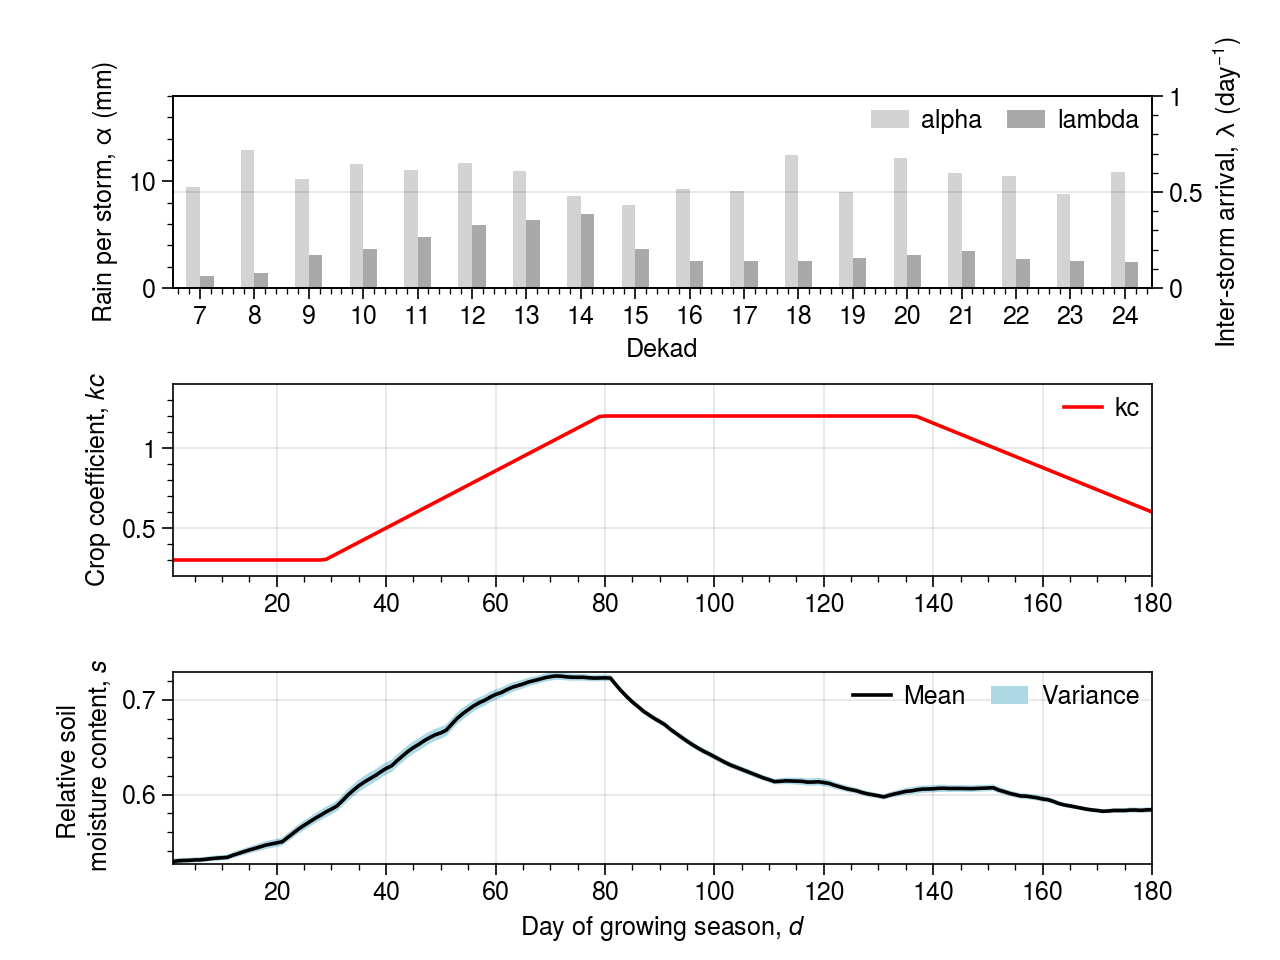

In [8]:
# figure set up
# nice figure that should go in the paper
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, sharex=False)
#fig, axs = plot.subplots(nrows=3, ncols=1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  0.5    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
#axs.format(abc=True, abcloc='ul', suptitle='Non-stationarity in Model Parameters')


# The amount of space above titles
#y_title_margin = 1.2

# Plot a) Rainfall climatology
# I'm not sure that I need anything from above

# now create a longer timeseries using month three to eight: March 1st and 1980 days later.

#subset dataframe
#ax1=axs[0]
df['doy'] = df[6:24]['dekad']*10 # this is already baked in actually
df = df[6:24].set_index('dekad').drop(['month_A','doy'], axis=1)
df

df.plot(kind="bar", ax=ax1, ylim=(0,18),rot=360, color=['lightgray','darkgray']) # hatch=('-','//')
ax1_ = ax1.twinx()
for r in ax1.patches[len(df):]:
    r.set_transform(ax1_.transData)

ax1.set_ylabel(r'Rain per storm, $\alpha$ (mm)')
ax1_.set_ylabel('Inter-storm arrival, $\lambda$ (day$^{-1}$)')
#ax1.set_xlabel([], color='white')
ax1.set_xlabel('Dekad')
ax1_.set_xlabel([''])

ax1.legend(frameon=False, ncol=2)
ax1.grid(which='major',axis='both')


# Plot b) Crop Coefficient
o = output[0]
o.index = o.index+1 # make doy cooperate better
ax2.plot(o['kc'], 'r-') 
ax2.set(ylabel='Crop coefficient, $\mathit{kc}$')
ax2.set_ylim(0.2, 1.4)
ax2.legend(['kc'],frameon=False)

# Plot c) Saturation
# get average saturation
avg_df_180 = pd.concat([df['s'] for df in output], axis=1)                          
avg_df_180["mean"] = avg_df_180.mean(axis=1)  
avg_df_180["var"] = avg_df_180.var(axis=1)  
df_180 = avg_df_180
df_180 = df_180[0:180] ##############!!!!!!!!!!!!!!!! something is goofy here, come back and take a look
df_180.index = df_180.index+1 # make doy cooperate better

ax3.plot(df_180['mean'], 'k-')
x = np.arange(1, len(df_180)+1, 1)
ax3.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
ax3.set(xlabel='Day of growing season, $\mathit{d}$')
ax3.legend(['Mean', 'Variance'], ncol=2, frameon=False)
ax3.set(ylabel='Relative soil \n moisture content, $\mathit{s}$')
plt.savefig('../output/6-results/threefigs_dekadal.png',format='png')

### Fig. 4 Dynamic Stress-Yield Relationship <a id='yields'></a>

In [10]:
# line up the data
data = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output] #for i in np.arange(n_sim)
rf = [df['R'].sum() for df in output]

In [11]:
# Turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf
print(max(df.Yield)/1000)

3.616986779598881


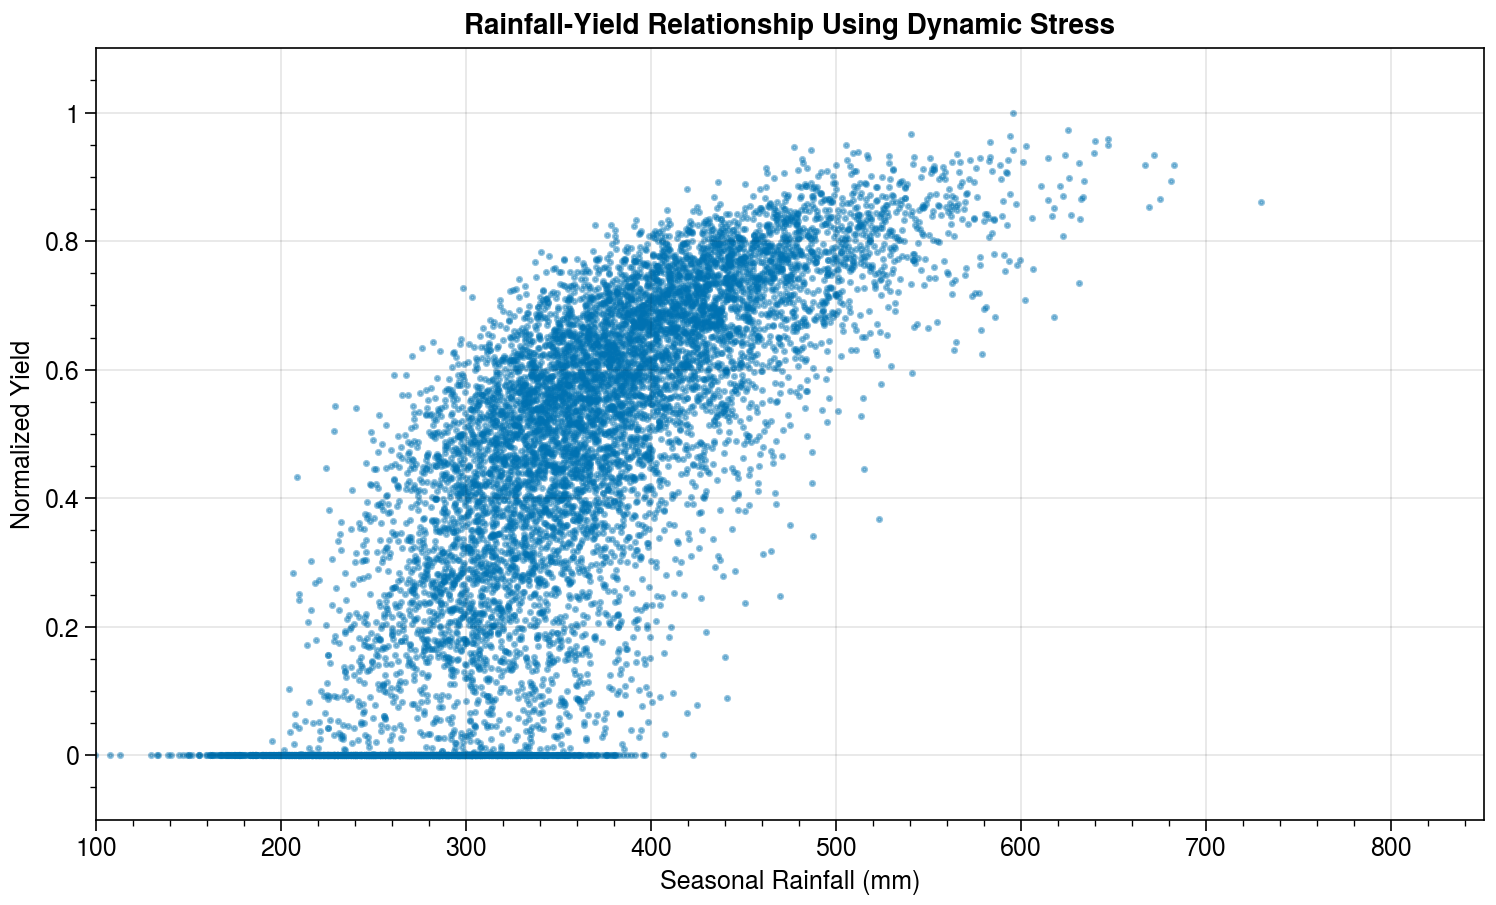

In [13]:
# Dynamic Stress Yield Rlxn

def fig3(df=None):
    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Scatter plot of raw data
    max(df.Yield)

    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu2') #, tight=False
    axs.format(
        abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
    
    
    plt.scatter(df.RF, df.Yield_norm, alpha=0.4, size=2.5) # , color='black'
    plt.ylim(-.10,1.10)
    plt.xlim(100,850)
    #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
    plt.ylabel('Normalized Yield') # Yield normalized by max. yield
    plt.xlabel('Seasonal Rainfall (mm)')
    plt.savefig('../output/6-results/dynstress2.png',format='png')
    # New fit
    #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
    #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
    # confidence intervals around line?
    
fig3(df=df)

## Step 3. Export then import simulations for varieties <a id='import2'></a>

In [38]:
# Started off with this but doesn't have evolved calc yields. Need to combine what's below with what's above.

# This timed out. 
def run2():

    # Now I have to re-run the simulations using the max yields from this relationship
    varieties = np.arange(75,180,5)
    len(varieties)

    result = []

    for i in varieties:
        # note: bumping up to 200 sims per cultivar type takes several minutes to run
        # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
        data, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
        df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
        df['RF'] = rf
        df['Cultivar'] = i
        result.append(df)
        
    return result

result = run2()
result = pd.concat(result)

# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this
def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"

for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

Medium (110 - 140 d)    3500
Late (145 + d)          3500
Early (< 105 d)         3500
Name: Category, dtype: int64

In [39]:
result.to_csv('../output/result08302020.csv',sep=',')

### LGP impacts on yield <a id='lgp'></a>

In [ ]:
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                            ann_x = 101, ann_y = 4500, 
                            x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = False):
        """ Computes linear regression between independent and dependent variable. 
        Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
            ann_x = where on x-axis annotation should be placed
            ann_y = where on y-axis annotation should be placed
            Returns: R_squared, m, b
        """
        # Define variables
        X, y = x_var, y_var

        # Linear regression
        denominator = X.dot(X) - X.mean() * X.sum()
        m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
        b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

        y_pred = m*X + b

        # uncomment for white figure
        col = 'black'
        #col = 'white'
        
        
        plt.figure(figsize=(5,4))

        g = sns.lmplot(x_str, y_str, data, ci=95, height=4, scatter_kws={'color':col,'alpha':0.6}) # ,, line_kws={'color': 'black'}

        # Calculate residuals
        res = y - y_pred
        tot = y - y.mean()

        R_squared = 1 - res.dot(res) / tot.dot(tot)
        print(R_squared)
        print('m',m)
        print('b',b)

        if positive == True:
            textstr = '\n'.join((
                r'$ y = %.2f$x' % (m, )+'+$  %0.1f$' % (b, ),
                r'$r^2 = %.2f$' % (R_squared, ))) 
        else:
            textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'$  %.1f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, )))

        props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5) # , ec="b"

        # place a text box in upper left in axes coords
        plt.text(ann_x, ann_y, textstr, fontsize=10, #transform=ax.transAxes, 
                verticalalignment='top', bbox=props)

        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        plt.ylim(1,5.2)
        plt.title(title, fontweight="bold")

        return R_squared, m, b
    
def fig4():
    # verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
    verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
    verified_hybrid_data


    # convert to metric tons
    verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
    verified_hybrid_data
    

    p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                                  'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                                  85, 5, 'Days to Maturity (days)', 'Potential Yield (tons/ha)', 
                                  'Kenya Seed Co. Potential Yields by Maize Variety')
    
fig4()
plt.savefig('../output/6-results/ksc.pdf',format='pdf')
plt.savefig('../output/6-results/ksc.png',format='png')

### Summary statistics

In [ ]:
# Note to self, this is for getting yields in G3S talk.
x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output]
print(x[847])
print(output[847][start:end]['R'].sum())

In [ ]:
# want to have table average yield, average rainfall

df = pd.DataFrame(x)
print(df[2].describe())
print(df[2].median())

s_min = []

# rainfall statistics
for i in no_sims:
    #print(output[i][start:end]['s'].min())
    _s_min = output[i][start:end]['R'].sum()
    s_min.append(_s_min)
result = pd.DataFrame({'s_min':s_min})
result.s_min.median()

In [ ]:
# need to output the 10,000 simulations into one dataframe (?) for export
# But then also need to truncate just to start and end for each sim.
# Should be able to do that using a for loop.
#pd.concat(output)
#plt.rcParams.keys()

Notes: How to bound the kde fit on static water stress to zero?
* [DataCamp](https://www.datacamp.com/community/tutorials/probability-distributions-python) article talks about distributions and exponential one still has curve that overflows to zero.
* [Stackoverflow](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python) says only option is to cut the axis limits to zero. Also [here](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python). Explanation for why you can get negative values from a positive density kernel density estimation, [stackexchange](https://stats.stackexchange.com/questions/109549/negative-density-for-non-negative-variables).

## Previous code (to delete)

In [ ]:
Do evolved calc yield
def evolved_calc_yield(dtm=None, m = None, b = None):
    yield_kg_ha = m*dtm + b

    if dtm > 185:
        raise ValueError("days to maturity, {dtm} is larger than 175".format(
                dtm=dtm))
    if dtm < 68:
        raise ValueError("days to maturity, {dtm} is less than 68".format(
                dtm=dtm))

    return yield_kg_ha

## Part 0. Account for different maximum yields
# verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')

# convert to metric tons
verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                             'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                             85, 4.9, 'Days to Maturity (days)', 'Yield (tons/ha)', 
                             'Potential Maize Yields from Kenya Seed Company', positive=False)

#plt.savefig('../output/6-results/ksc.png',format='png')

In [ ]:
def model_runs(n_sim = 1000, burn_in = 60, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    doy = abs(burn_in - pd_sim) # absolute value

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=doy)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    planting_date = pd_sim
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = burn_in 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    sat = [df[start:end]['s'] for df in output]
    stress = [df[start:end]['stress'] for df in output]
    
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    # prev crop.calc_dstress
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o] #for i in np.arange(n_sim)
    #print(x)
    
    # Part 7. Define kc
    start = burn_in
    end = burn_in + lgp
    kc = o[1][start:end]['kc'].tolist()
    
    return  x, total_rf, sat, stress, o, crop, output, kc, start, end #output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha

# Note: Not great practice to return all of these variables, but for testing it's useful
data, rf, sat, stress, o, crop, output, kc, start, end = model_runs()

In [ ]:
# I don't actually use these plots in the MS
# Do scatter plot with three variety types

f, axs = plot.subplots(nrows=1, ncols=3, journal='agu2', spanx=True, tight=True) #, tight=False

result['Yield_norm'] = result.Yield/max(result.Yield)
datas = ["Category == 'Early (< 105 d)'", "Category == 'Medium (110 - 140 d)'", "Category == 'Late (145 + d)'"]

# one option for colors
#import matplotlib.cm as cm
#colors = cm.rainbow(np.linspace(0, 1, 3))

# another option for colors
red = sns.color_palette("reds")[-2] 
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-1]
colors = [red, yellow, blue]

for ax, data, c in zip(axs, datas, colors):
    dat = result.query(data)
    ax.scatter(dat.RF, dat.Yield_norm, color=c)

axs.format(xlim=(0, 900), ylim=(-0.05, 1.05), 
    abc=True, xlabel='Rainfall (mm)', ylabel='Yield normalized by max. yield', abcloc='ul', 
           collabels=['Early', 'Medium', 'Late'],
           suptitle='Rainfall-Yield Relationship Using Dynamic Stress (k=0.2, r=0.5)')

#plt.savefig('../output/figures/yieldrf.png',format='png')


### Previous three figures

In [5]:
def check_exponential(data):

    """ Defines function that fits daily rainfall amounts to an exponential distribution and returns pdf 
        and r2. The r2 should be above 0.9 to be an exponential.

        Usage:

            check_exponential(data):

                returns r2, pdf

        How it works:
        - Step 1: To fit the distribution, we use functions from python's suite of numerical analysis, scipy.
        The scipy.stats module has a large suite of distribution functions pre-defined, which we can use to 
        develop a fit for our data. The distribution we are interested in is the exponential distribution, 
        which is called expon in the stats module.

        - Step 2-4: Calculate fitted PDF and error with fit in distribution. To test the fit of our distribution, 
        we can compare the empirical histogram to that predicted by our model. We first use our `data` to generate 
        the empirical histogram. In this example, we break the data into `30` bins, and we generate a histrogram 
        of `density` rather than counts. This allows for an easier comparison between our empirical data and the 
        fitted probability distribution function. 
        
        Here are the steps:

        1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
        2. Shift the `x` bin locations generated from the histogram to the center of bins.
        3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
        4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according 
        to the equations in rainfall-variability.ipynb.
    """

    # Step 1. Fit the distribution.
    distribution = st.expon
    params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    y, x = np.histogram(data, bins=30, density=True)

    # Step 2. Shift the x bin locations to the center of bins.
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Step 3. Calculate the values of pdx(x) for all x.
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

    # Step 4. Determine the residual and total sum of the squares.
    ss_error = np.sum(np.power(y - pdf, 2.0))
    ss_yy = np.sum(np.power(y - y.mean(), 2.0))

    r_2 = 1 - ( ss_error / ss_yy )

    if r_2 < 0.9:
        print("WARNING. r2 for {station} is {r_2}".format(
            station=station,
            r_2=r_2))

    return r_2, pdf

In [6]:
def make_climate_parameters(
        station='OL JOGI FARM',
        data_file=module_path + '/data/CETRAD/CETRAD_rainfall.csv',
        year_min=30,
        interval='month'):
    """ 


    TODO: WRITE DOCSTRINGS




    """

    # Prepare the CETRAD dataset.
    year_min = year_min # minimum number of years to consider for a valid climate record.

    df = pd.read_csv(data_file)  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]
    df['Week'] = [dt.week for dt in df['Datetime']]
    df['Semi_Month'] = (df['Datetime'].dt.day
                          .gt((df['Datetime']+pd.tseries.offsets.MonthEnd()).dt.day//2) 
                          + df['Month']*2 -1)
    df['Dekad'] = df['Datetime'].dt.dayofyear//10+1
    
    n_years = len(df['Year'].unique())

    # # Check to make sure we have enough data for fitting and parameter estimation.
    if n_years < year_min:
        print("WARNING! Station record for {station} has only {n_years} years.".format(
            station=station,
            n_years=n_years))

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Semi_Month','Datetime']
    rainfall = df[columns]

    # First, find all the rows in the data where it rained and group by month.
    rain_days = rainfall.loc[rainfall[station] > 0]

    # Find all locations in the data where an observation was made.
    all_days = rainfall.loc[rainfall[station] >= 0]

    # Find just the rainfall amounts on days that it rained.
    data = rainfall.loc[rainfall[station] > 0][station]

    # Fit the daily rainfall amounts to an exponential distribution.
    check_exponential(data)

    if interval == 'month':
        # Determine the Monthly values of alpha and lambda from the station data:
        lambda_values = (
            rain_days.groupby('Month')[station].count() /
            all_days.groupby('Month')[station].count()
        )
        alpha_values = rain_days.groupby('Month')[station].mean()
    elif interval == 'week':
        lambda_values = (
            rain_days.groupby('Week')[station].count() / 
            all_days.groupby('Week')[station].count()
        )
        alpha_values = rain_days.groupby('Week')[station].mean()
    elif interval == 'dekad':
        lambda_values = (
            rain_days.groupby('Dekad')[station].count() / 
            all_days.groupby('Dekad')[station].count()
        )
        alpha_values = rain_days.groupby('Dekad')[station].mean()
    elif interval == 'semi_month':
        lambda_values = (
            rain_days.groupby('Semi_Month')[station].count() / 
            all_days.groupby('Semi_Month')[station].count()
        )
        alpha_values = rain_days.groupby('Semi_Month')[station].mean()
    # MAKE THE CLIMATE PARAMETER DICT:

    return alpha_values.to_list(), lambda_values.to_list()

[Text(0, 0.5, 'Relative soil \n moisture content, $\\mathit{s}$')]

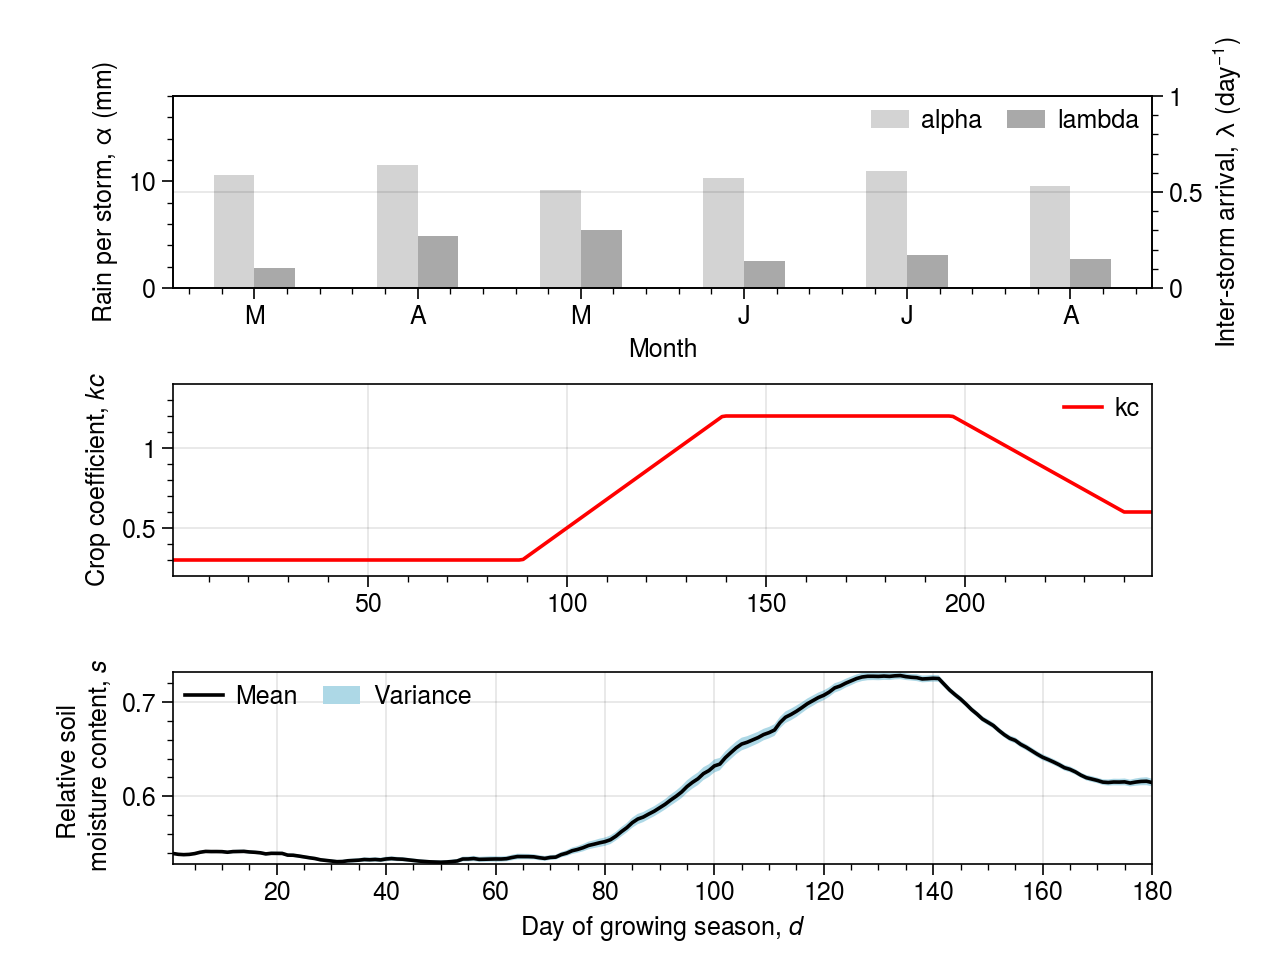

In [12]:
# figure set up
# nice figure that should go in the paper
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, sharex=False)
#fig, axs = plot.subplots(nrows=3, ncols=1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  0.5    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
#axs.format(abc=True, abcloc='ul', suptitle='Non-stationarity in Model Parameters')


# The amount of space above titles
#y_title_margin = 1.2

# Plot a) Rainfall climatology
# I'm not sure that I need anything from above

alpha_monthly, lambda_monthly = make_climate_parameters()
# make a dataframe
df = pd.DataFrame({'alpha':alpha_monthly, 'lambda':lambda_monthly, 'month':np.arange(1,13,1),'month_A':['J','F','M','A',
                                                                           'M','J','J','A','S','O','N','D']})
# now create a longer timeseries using month three to eight: March 1st and 1980 days later.

#subset dataframe
#ax1=axs[0]
df['doy'] = df[2:8]['month']*30
df = df[2:8].set_index('month_A').drop(['month','doy'], axis=1)

df.plot(kind="bar", ax=ax1, ylim=(0,18),rot=360, color=['lightgray','darkgray']) # hatch=('-','//')
ax1_ = ax1.twinx()
for r in ax1.patches[len(df):]:
    r.set_transform(ax1_.transData)

ax1.set_ylabel(r'Rain per storm, $\alpha$ (mm)')
ax1_.set_ylabel('Inter-storm arrival, $\lambda$ (day$^{-1}$)')
#ax1.set_xlabel([], color='white')
ax1.set_xlabel('Month')
ax1_.set_xlabel([''])

ax1.legend(frameon=False, ncol=2)
ax1.grid(which='major',axis='both')


# Plot b) Crop Coefficient
o = output[0]
o.index = o.index+1 # make doy cooperate better
ax2.plot(o['kc'], 'r-') 
ax2.set(ylabel='Crop coefficient, $\mathit{kc}$')
ax2.set_ylim(0.2, 1.4)
ax2.legend(['kc'],frameon=False)

# Plot c) Saturation
# get average saturation
avg_df_180 = pd.concat([df['s'] for df in output], axis=1)                          
avg_df_180["mean"] = avg_df_180.mean(axis=1)  
avg_df_180["var"] = avg_df_180.var(axis=1)  
df_180 = avg_df_180
df_180 = df_180[0:180] ##############!!!!!!!!!!!!!!!! something is goofy here, come back and take a look
df_180.index = df_180.index+1 # make doy cooperate better

ax3.plot(df_180['mean'], 'k-')
x = np.arange(1, len(df_180)+1, 1)
ax3.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
ax3.set(xlabel='Day of growing season, $\mathit{d}$')
ax3.legend(['Mean', 'Variance'], ncol=2, frameon=False)
ax3.set(ylabel='Relative soil \n moisture content, $\mathit{s}$')
plt.savefig('../output/6-results/threefigs.png',format='png')
